In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

import sys
sys.path.append('/bsuhome/zacharykeskinen/uavsar-coherence/src/funcs')
from xarray_tools import find_cor_ts
from stats import get_stats, clean_xs_ys, fit_lm
sys.path.append('/bsuhome/zacharykeskinen/uavsar-coherence/src/constants')
from colors import loc_colors

In [26]:
dss = {fp.stem.split('_')[0]: xr.open_dataset(fp) for fp in Path('~/scratch/coherence/uavsar').expanduser().glob('*_tau.nc')}

In [37]:
out_dir = Path('/bsuhome/zacharykeskinen/scratch/coherence/model')
# res = np.fromfile(out_dir.joinpath('polarizations_dswes_cummelt_swes.npy'))

from itertools import product
from tqdm import tqdm

cors = np.array([[],[],[],[]])
dswes = np.array([])
cummelts = np.array([])
swes = np.array([])
trees = np.array([])
incs = np.array([])
for stem, ds in dss.items():

    ts = find_cor_ts(ds)
    name = loc_colors[stem]['name']
    print(name)

    # ds = ds.where((ds['tree_perc'] < 10) & (ds["inc"] < np.deg2rad(60))& (ds["inc"] > np.deg2rad(30)))

    for heading, t1, t2 in tqdm(ts):
        inc = ds['inc'].sel(heading = heading).values.ravel()
        tree = ds['tree_perc'].values.ravel()

        # tree_inc_idx = (trees < 10) & (inc < np.deg2rad(60)) & (inc > np.deg2rad(30))

        t1, t2 = pd.to_datetime(t1), pd.to_datetime(t2)
        # if (t2 - t1).days > 13: continue
        vv = ds['cor'].sel(time1 = t1, time2 = t2, heading = heading, pol = 'VV').values.ravel()
        vh = ds['cor'].sel(time1 = t1, time2 = t2, heading = heading, pol = 'VH').values.ravel()
        hv = ds['cor'].sel(time1 = t1, time2 = t2, heading = heading, pol = 'HV').values.ravel()
        hh = ds['cor'].sel(time1 = t1, time2 = t2, heading = heading, pol = 'HH').values.ravel()
        model = ds[['model_sd', 'model_melt', 'model_swe']].sel(model_time = slice(t1, t2))

        d_swe = (model['model_swe'].isel(model_time = -1) - model['model_swe'].isel(model_time = 0)).values.ravel()  / (t2 - t1).days
        cum_melt = model['model_melt'].sum('model_time').values.ravel() / (t2 - t1).days
        swe = model['model_swe'].isel(model_time = -1).values.ravel()

        cor_idx = (~np.isnan(vv)) & (~np.isnan(vh)) & (~np.isnan(hv)) & (~np.isnan(hh))
        idx = (cor_idx) & (~np.isnan(d_swe)) & (~np.isnan(cum_melt)) & (~np.isnan(swe)) & (~np.isnan(tree)) & (~np.isnan(inc))

        vv, hv, vh, hh = vv[idx], hv[idx], vh[idx], hh[idx]
        d_swe, cum_melt, swe = d_swe[idx], cum_melt[idx], swe[idx]
        tree, inc = tree[idx], inc[idx]
        cors = np.concatenate([cors, np.vstack([vv, hv, vh, hh])], axis = 1)
        dswes = np.concatenate([dswes, d_swe])
        cummelts = np.concatenate([cummelts, cum_melt])
        swes = np.concatenate([swes, swe])
        trees = np.concatenate([trees, tree])
        incs = np.concatenate([incs, inc])
np.vstack([cors, dswes, cummelts, swes, trees, incs]).tofile(out_dir.joinpath('polarizations_dswes_cummelt_swes.npy'))

Rocky Mountain NP, CO


 48%|████▊     | 10/21 [00:06<00:07,  1.44it/s]/tmp/ipykernel_259727/3829691173.py:35: RuntimeWarning: invalid value encountered in divide
  d_swe = (model['model_swe'].isel(model_time = -1) - model['model_swe'].isel(model_time = 0)).values.ravel()  / (t2 - t1).days
/tmp/ipykernel_259727/3829691173.py:36: RuntimeWarning: invalid value encountered in divide
  cum_melt = model['model_melt'].sum('model_time').values.ravel() / (t2 - t1).days
100%|██████████| 21/21 [00:13<00:00,  1.54it/s]


Alamos, NM


100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Grand Mesa, CO


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Uticam, MT


100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


Peeler, CO


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Dorado, CA


100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Ironton, CO


100%|██████████| 9/9 [00:12<00:00,  1.39s/it]


Reynold Creek, ID


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Fraser, CO


100%|██████████| 16/16 [00:29<00:00,  1.85s/it]


Lowman, ID


100%|██████████| 17/17 [01:09<00:00,  4.09s/it]


St. Lake, UT


100%|██████████| 21/21 [01:07<00:00,  3.20s/it]


Sierra, CA


100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


In [67]:
out_dir = Path('/bsuhome/zacharykeskinen/scratch/coherence/model')

res = np.fromfile(out_dir.joinpath('polarizations_dswes_cummelt_swes.npy'))
res = res.reshape(9, -1).T
res = pd.DataFrame(res, columns = ['VV', 'HV', 'VH', 'HH', 'dswe', 'cummelt', 'swe', 'trees', 'inc'])
sub = res.loc[(res[['VV', 'HH', 'VH', 'HV']].mean(axis = 1) > 0.5) & (res['cummelt'] == 0) & (res['dswe'] > 0), :]

In [80]:
fig_dir = Path('/bsuhome/zacharykeskinen/uavsar-coherence/figures/polarization/model')

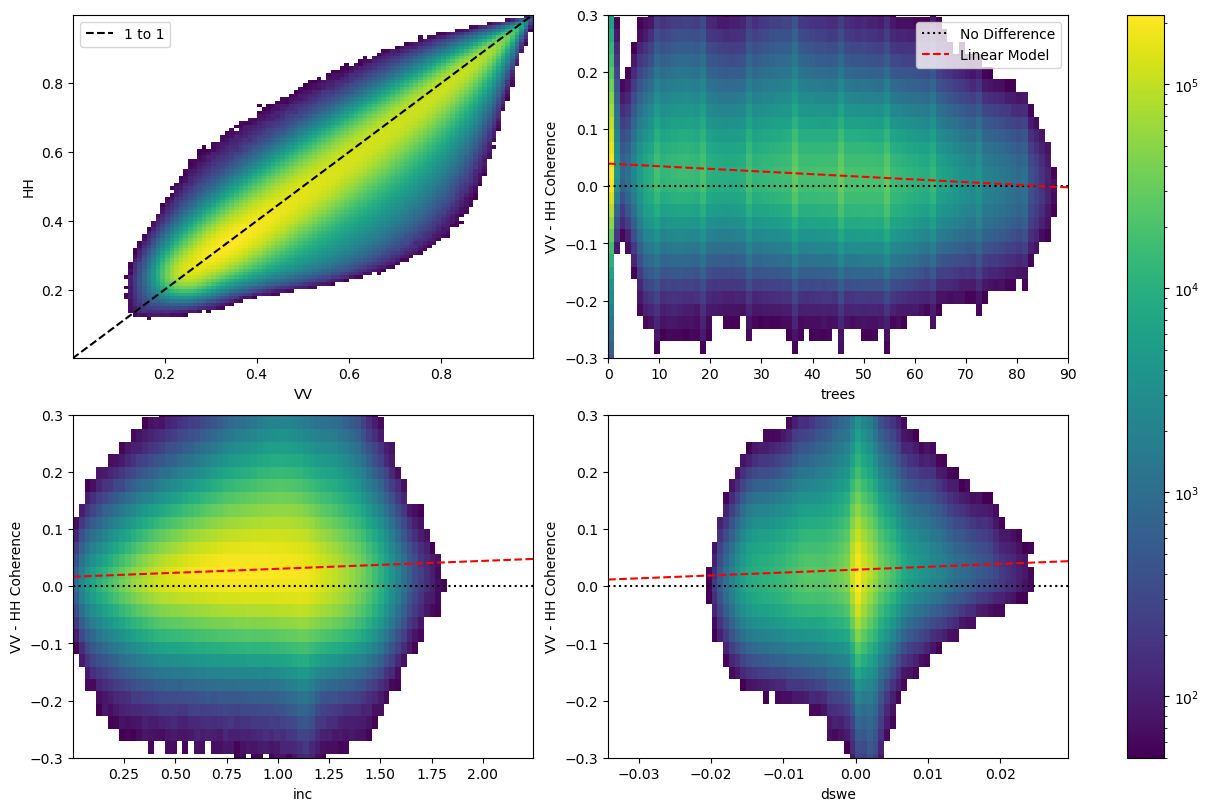

In [81]:
fig, axes = plt.subplots(2, 2, figsize = (12, 8), layout = 'compressed')

ax = axes[0, 0]
h = ax.hist2d(res['VV'], res['HH'], bins = 100, norm = 'log', cmin = 50)
# fig.colorbar(h[3])
ax.set_xlabel('VV')
ax.set_ylabel('HH')
ax.plot([0, 1], [0, 1], color = 'k', linestyle = 'dashed', label = '1 to 1')

def polarization_diff_plot(diff, x_label, ax):
    ax.hist2d(sub[x_label], diff, bins = 80, norm = 'log', cmin = 50)
    ax.set_xlabel(x_label)
    ax.set_ylabel('VV - HH Coherence')
    ax.set_ylim(-0.3, 0.3)

    ax.axhline(0, color = 'k', linestyle = 'dotted', label = 'No Difference')

    rmse, r, n = get_stats(sub[x_label], diff)
    rs, intercept, coe = fit_lm(sub[x_label], diff)
    ax.plot(np.linspace(sub[x_label].min(), sub[x_label].max(), 100), intercept + coe*np.linspace(sub[x_label].min(), sub[x_label].max(), 100), color = 'red', linestyle = 'dashed', label = 'Linear Model')

diff = sub['VV'] - sub['HH'] # positive means VV is bigger

for ax, label in zip(axes.ravel()[1:], ['trees', 'inc', 'dswe']):
    polarization_diff_plot(diff, label, ax)

plt.colorbar(h[3], ax = axes.ravel().tolist()) 
axes.ravel()[0].legend()
axes.ravel()[1].legend()
# plt.tight_layout()
plt.savefig(fig_dir.joinpath('copol_compare.png'))

In [77]:
out_dir = Path('/bsuhome/zacharykeskinen/scratch/coherence/model')

res = np.fromfile(out_dir.joinpath('polarizations_dswes_cummelt_swes.npy'))
res = res.reshape(9, -1).T
res = pd.DataFrame(res, columns = ['VV', 'HV', 'VH', 'HH', 'dswe', 'cummelt', 'swe', 'trees', 'inc'])
sub = res.loc[(res[['VV', 'HH', 'VH', 'HV']].mean(axis = 1) > 0.5), :]

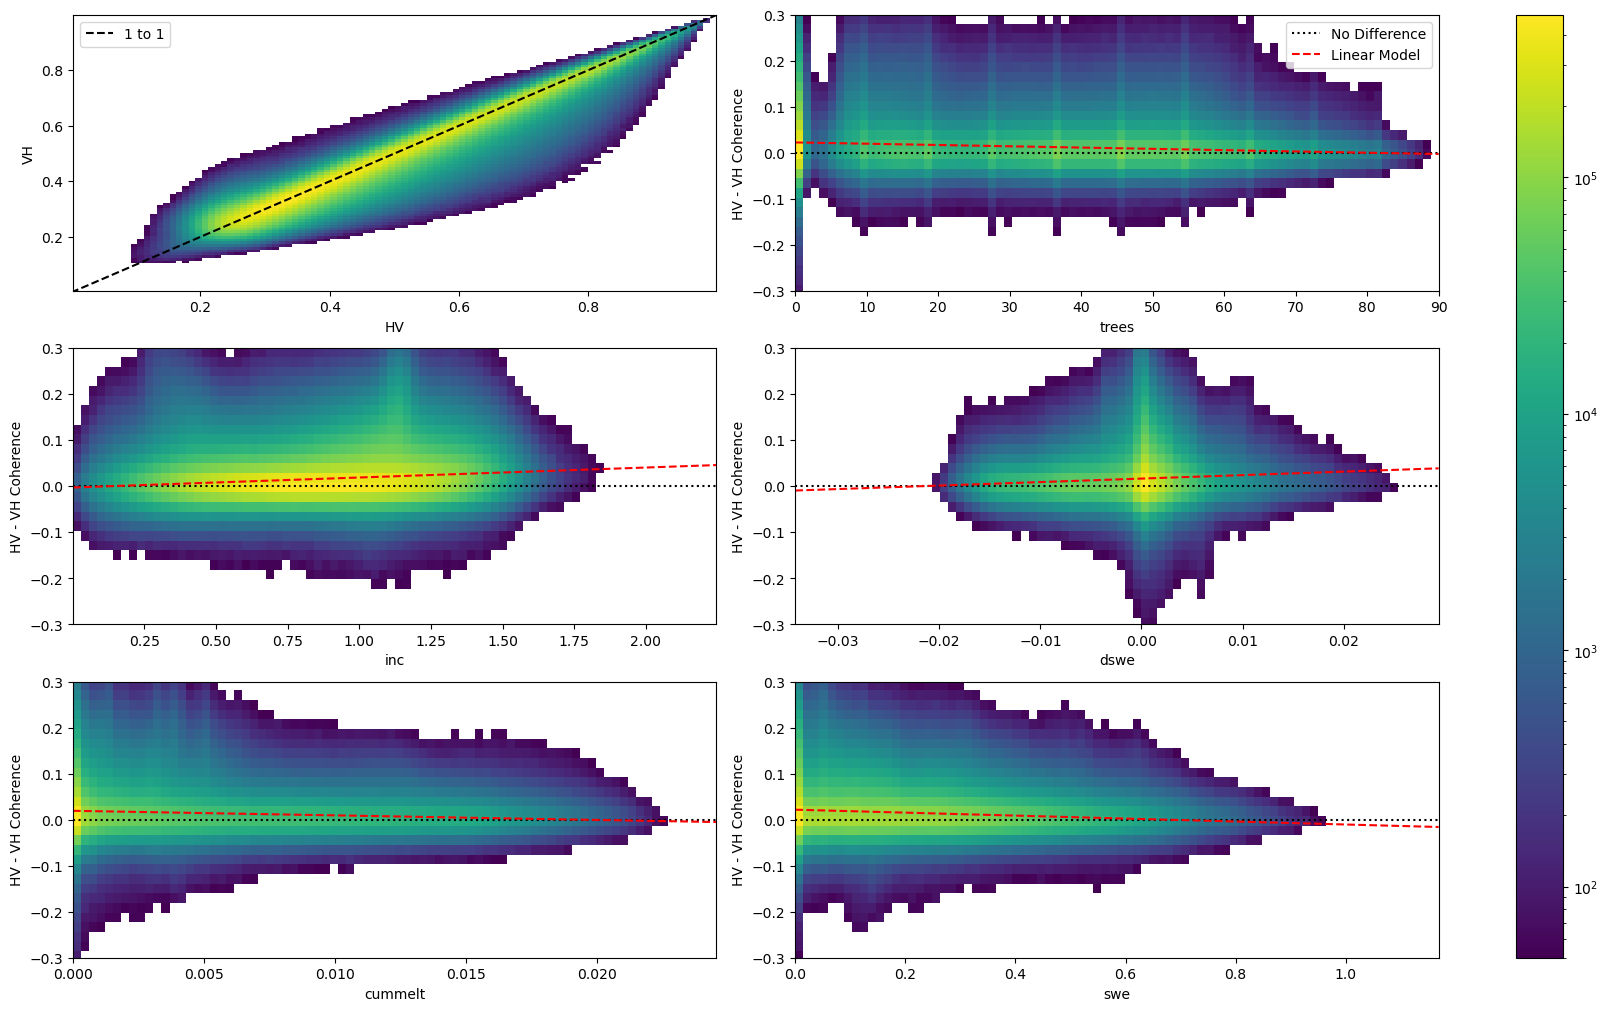

In [79]:
fig, axes = plt.subplots(3, 2, figsize = (16, 10), layout='compressed')

ax = axes[0, 0]
h = ax.hist2d(res['HV'], res['VH'], bins = 100, norm = 'log', cmin = 50)
# fig.colorbar(h[3])
ax.set_xlabel('HV')
ax.set_ylabel('VH')
ax.plot([0, 1], [0, 1], color = 'k', linestyle = 'dashed', label = '1 to 1')

def polarization_diff_plot(diff, x_label, ax):
    ax.hist2d(sub[x_label], diff, bins = 80, norm = 'log', cmin = 50)
    ax.set_xlabel(x_label)
    ax.set_ylabel('HV - VH Coherence')
    ax.set_ylim(-0.3, 0.3)

    ax.axhline(0, color = 'k', linestyle = 'dotted', label = 'No Difference')

    rmse, r, n = get_stats(sub[x_label], diff)
    rs, intercept, coe = fit_lm(sub[x_label], diff)
    ax.plot(np.linspace(sub[x_label].min(), sub[x_label].max(), 100), intercept + coe*np.linspace(sub[x_label].min(), sub[x_label].max(), 100), color = 'red', linestyle = 'dashed', label = 'Linear Model')

diff = sub['HV'] - sub['VH'] # positive means VH is bigger

for ax, label in zip(axes.ravel()[1:], ['trees', 'inc', 'dswe', 'cummelt', 'swe']):
    polarization_diff_plot(diff, label, ax)

axes.ravel()[0].legend()
axes.ravel()[1].legend()

plt.colorbar(h[3], ax = axes.ravel().tolist()) 
plt.savefig(fig_dir.joinpath('crosspol_compare.png'))

# THIS IS OLD AND FOR ALL WITH NO SUBSETTING!!

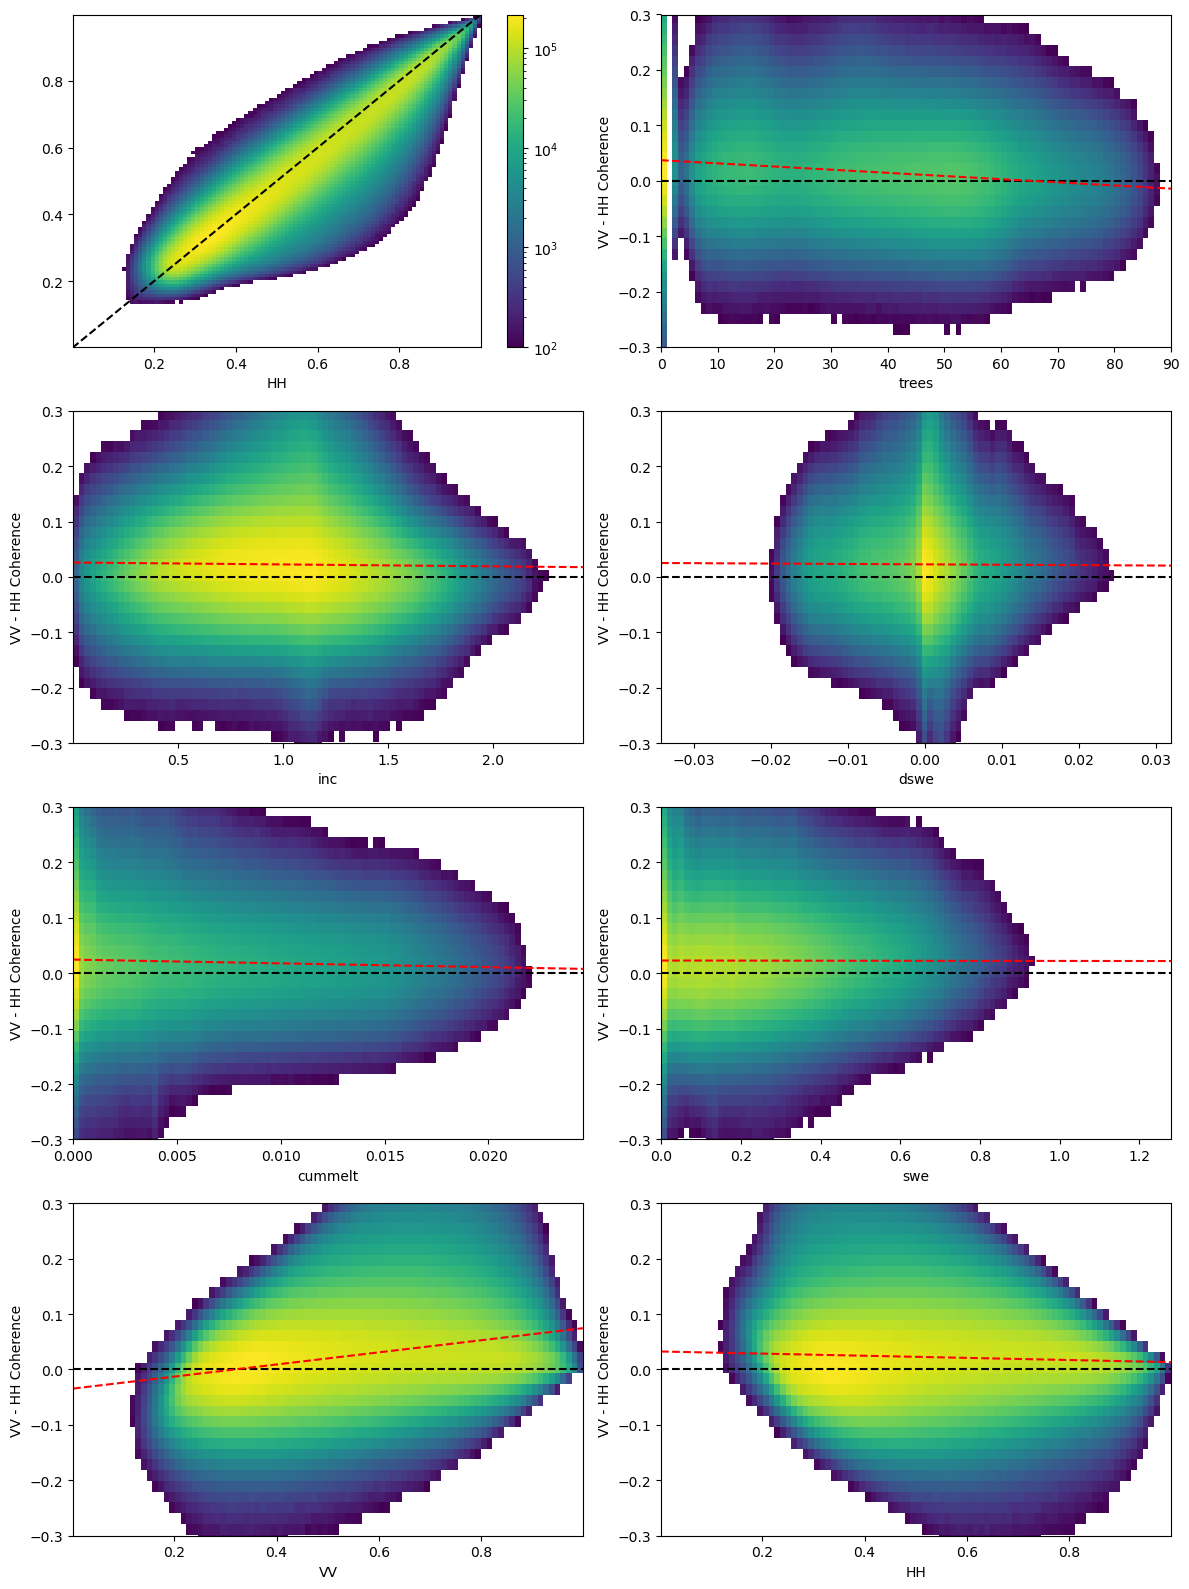

In [3]:
fig, axes = plt.subplots(4, 2, figsize = (12, 16))

ax = axes[0, 0]
h = ax.hist2d(res['VV'], res['HH'], bins = 100, norm = 'log', cmin = 100)
fig.colorbar(h[3])
ax.set_xlabel('VV')
ax.set_xlabel('HH')
ax.plot([0, 1], [0, 1], color = 'k', linestyle = 'dashed')

def polarization_diff_plot(diff, x_label, ax):
    ax.hist2d(res[x_label], diff, bins = 90, norm = 'log', cmin = 100)
    ax.set_xlabel(x_label)
    ax.set_ylabel('VV - HH Coherence')
    ax.set_ylim(-0.3, 0.3)

    ax.axhline(0, color = 'k', linestyle = 'dashed')

    rmse, r, n = get_stats(res[x_label], diff)
    rs, intercept, coe = fit_lm(res[x_label], diff)
    ax.plot(np.linspace(res[x_label].min(), res[x_label].max(), 100), intercept + coe*np.linspace(res[x_label].min(), res[x_label].max(), 100), color = 'red', linestyle = 'dashed')

diff = res['VV'] - res['HH'] # positive means VV is bigger

for ax, label in zip(axes.ravel()[1:], ['trees', 'inc', 'dswe', 'cummelt', 'swe', 'VV', 'HH']):
    polarization_diff_plot(diff, label, ax)

plt.tight_layout()